In [4]:
from collections import Counter
import os
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import sys 
sys.path.append('/work/')
# Module for implementing the GERANIO pipeline
from importlib import reload
import file_converters as f
import running_algorithms as r
import general_mapping as g
import analysis as a
import drawing as d 

Evomine and GERM are provided as binary executable. Pay attention to GERM executable since it has been compiled for Intelx86 architecture.

**Note**: Execute this code block every time you restart the machine, if you are in a cloud environment like DeepNote or Lightning AI.

In [5]:
! chmod +x ./algorithms/evomine
! chmod +x ./algorithms/germ

In [6]:
reload(f)
reload(r)
reload(g)
reload(a)
reload(d)

<module 'drawing' from '/root/work/drawing.py'>

<img src = 'imgs/pipeline.png' width = 90%>

In [13]:
f.from_txtfile_to_gerinput(input_path = './raw-datasets/dblp0305.txt', 
                           output_path = './input-files/[ger-ready]-dblp0305.txt', 
                           separator = ' ')

removed ./input-files/[ger-ready]-dblp0305.txt
Edge list converted, ger format file saved in  ./input-files/[ger-ready]-dblp0305.txt


The utility function `from_txtfile_to_gerinput` converts the input file into a GER-ready format. The output file is structured into two parts:
- the first part contains the list of nodes: each line has the format `v <id_node> timestamp`
- the second part contains the list of edges: each line has the format `e <id_source> <id_target> timestamp`

# RUN algorithm

The second step of the pipeline is to run the GER algorithm. The algorithm is executed by the function `run_algorithm` in the module `running_algorithms`.The function `run_algorithm` is a wrapper for running the GER algorithm. The function takes as input the following parameters:
- `algo`: the algorithm to run (either `germ` or `evomine`)
- `sup`: the minimum support threshold
- `maxedge`: the maximum number of edges in the pattern
- `filename`: the path to the input file
- `outputfile`: the path to the output file
- `projection`: type of support, i.e. MIB or event-base support
- `directed`: if `True`, the graph is directed
- `edge_color`: if `True`, the graph has edge colors
- `node_color`: if `True`, the graph has node colors
- `verbose`: if `True`, the function prints the output of the algorithm

## GERM 

### DBLP0305
We run GERM on the DBLP snapshot between 2003 and 2005

In [27]:
s = 5000 # support threshoold
m = 3 # maximum number of edges to be put into the body pattern.

In [19]:
algorithm = 'germ'
r.run_algorithm(algo = algorithm, 
              sup = s, 
              maxedge = m, 
              filename = './input-files/[ger-ready]-dblp0305.txt', 
              outputfile = f'[{algorithm}]dblp0305.{s}.{m}.txt',    
              verbose = False)

### DBLP0507
We run GERM on the DBLP snapshot between 2005 and 2007

In [22]:
s, m, algorithm = 5000, 3, 'germ'
r.run_algorithm(algo = 'germ', 
              sup = s, 
              maxedge = m, 
              filename = './input-files/dblp0507', 
              outputfile = f'[{algorithm}]dblp0507.{s}.{m}.txt',    
              verbose = True)

Running command:
./algorithms/germ 5000 ./input-files/dblp0507 3 > /dev/null
Output moved from ./input-files/dblp0507.out.5000.3.REL to ./output-files/[germ]dblp0507.5000.3.txt


## EvoMine

Run Evomine on **dblp0305**.

In [25]:
algorithm = 'EvoMine'
r.run_algorithm(algo = algorithm, 
              sup = s, 
              maxedge = m, 
              filename = './input-files/[ger-ready]-dblp0305.txt', 
              outputfile = f'[{algorithm}]dblp0305.{s}.{m}.txt',  
              directed = False,
              projection='full',
              #edge_color=True,
              #node_color=True,
              verbose = True)

Running command:
./algorithms/evomine -s 5000 -e 3 -T full -t -u -f ./input-files/[ger-ready]-dblp0305.txt > /dev/null
Output moved from ./input-files/[ger-ready]-dblp0305.txt.out.evomine.FULL.5000.3 to [EvoMine]dblp0305.5000.3.txt


Run Evomine on **dblp0507**.

In [28]:
s = 5000
m = 3
algorithm = 'EvoMine'
r.run_algorithm(algo = algorithm, 
              sup = s, 
              maxedge = m, 
              filename = './input-files/dblp0507', 
              outputfile = f'[{algorithm}]dblp0507.{s}.{m}.txt',  
              directed = False,
              projection='full',
              verbose = False)

The GERs computed by GERM or EvoMine are stored in a text file which follow the format:
```
t #<id_ger> <support>
v  <id_node> <timestamp?> # for each node in the pattern 
e # <id_source> <id_target> <timestamp> # for each edge in the pattern
```
For example, the following GER:
```
t #0 1000
v 0 0
v 1 0
v 2 0
v 3 0
e 0 1 0
e 0 3 2
e 1 2 2
```
can be visualized as 
<img src="imgs/germ_pattern_example.png" width="50%">

# CONVERT from output to ger list

## GERM

### dblp0305

In [9]:
g_info_list, g_patterns, g_support_patterns, g_mapping = f.from_ger_output(f'./output-files/[germ]dblp0305.5000.3.txt')
g_pattern_list, g_support = f.obtain_pattern_list(g_patterns, g_support_patterns, algorithm = 'germ')

By the functions `from_ger_output` and `obtain_pattern_list` we convert the output file into two dictionaries:
- `g_pattern_list`: a dictionary where the keys are the ids of the patterns (new ids) and the values are the edge list of the patterns, i.e. `[(s,d,t)...(s,d,t)]`
- `g_support`: a dictionary where the keys are the ids of the patterns and the values are the support of the patterns

### dblp0507

In [12]:
g_info_list_b, g_patterns_b, g_support_patterns_b, g_mapping_b = f.from_ger_output(f'./output-files/[germ]dblp0507.5000.3.txt')
g_pattern_list_b, g_support_b = f.obtain_pattern_list(g_patterns_b, g_support_patterns_b, algorithm = 'germ')

## EvoMine

### dblp0305

In [15]:
e_info_list, e_patterns, e_support_patterns, e_mapping = f.from_ger_output(f'./output-files/[EvoMine]dblp0305.5000.3.txt')
e_pattern_list, e_support = f.obtain_pattern_list(e_patterns, e_support_patterns, algorithm = 'evomine')

### dblp0507


In [18]:
e_info_list_b, e_patterns_b, e_support_patterns_b, e_mapping_b = f.from_ger_output(f'./output-files/[EvoMine]dblp0507.5000.3.txt')
e_pattern_list_b, e_support_b = f.obtain_pattern_list(e_patterns_b, e_support_patterns_b, algorithm = 'evomine')

# A canonical representation of GERs across different running

**Issue**: when EvoMine or GERM are run


## GERM

### dblp0305

In [33]:
reload(g)
g_new_pattern_list, g_new_support = g.mapping_pattern_ids('germ',g_pattern_list, g_support, 
                                                      general_mapping = pickle.load(open('germ_general_mapping.p','rb')), 
                                                      mapped_patterns_path = f'./processed-outputs/[mapped]-dblp0305.{s}.{m}', 
                                                      directed = False)

### dblp0507

In [36]:

g_new_pattern_list_b, g_new_support_b = g.mapping_pattern_ids('germ',g_pattern_list_b, g_support_b, 
                                                      general_mapping =  pickle.load(open('germ_general_mapping.p','rb')), 
                                                      mapped_patterns_path = f'./processed-outputs/[mapped]-dblp0507.{s}.{m}', 
                                                      directed = False)

In [39]:
g_pattern_list ,g_new_pattern_list

({0: ((0, 1, 0),),
  1: ((0, 1, 0), (1, 2, 0)),
  2: ((0, 1, 0), (0, 2, 0), (1, 2, 0)),
  3: ((0, 1, 0), (1, 2, 0), (2, 3, 0)),
  4: ((0, 1, 0), (1, 2, 0), (1, 3, 0)),
  5: ((0, 1, 0), (1, 2, 1)),
  6: ((0, 1, 0), (1, 2, 1), (2, 3, 1)),
  7: ((0, 1, 0), (1, 2, 0), (2, 3, 1)),
  8: ((0, 1, 0), (1, 2, 0), (1, 3, 1)),
  9: ((0, 1, 0), (1, 2, 1), (1, 3, 1)),
  10: ((0, 1, 0), (0, 3, 1), (1, 2, 1)),
  11: ((0, 1, 0), (1, 2, 2)),
  12: ((0, 1, 0), (1, 2, 2), (2, 3, 2)),
  13: ((0, 1, 0), (1, 2, 0), (2, 3, 2)),
  14: ((0, 1, 0), (1, 2, 1), (2, 3, 0)),
  15: ((0, 1, 0), (1, 2, 0), (1, 3, 2)),
  16: ((0, 1, 0), (1, 2, 2), (1, 3, 2)),
  17: ((0, 1, 0), (0, 2, 1), (1, 2, 1)),
  18: ((0, 1, 0), (0, 3, 2), (1, 2, 2)),
  19: ((0, 1, 0), (0, 3, 2), (1, 2, 1))},
 defaultdict(dict,
             {0: {'edges': [(0, 1, 0)], 'old-ids': 0},
              1: {'edges': [(0, 1, 0), (1, 2, 0)], 'old-ids': 1},
              2: {'edges': [(0, 1, 0), (0, 2, 0), (1, 2, 0)], 'old-ids': 2},
              3: {'edges':

## EvoMine

### dblp0305

In [79]:
e_new_pattern_list, e_new_support = g.mapping_pattern_ids('evomine',e_pattern_list, e_support, 
                                                      general_mapping = pickle.load(open('evomine_general_mapping.p','rb')), 
                                                      mapped_patterns_path = f'./processed-outputs/[mapped-Evomine]-dblp0305.{s}.{m}', 
                                                      directed = False)

### dblp0507

In [82]:
reload(g)
e_new_pattern_list_b, e_new_support_b = g.mapping_pattern_ids('evomine',e_pattern_list_b, e_support_b, 
                                                      general_mapping = pickle.load(open('evomine_general_mapping.p','rb')),
                                                      mapped_patterns_path = f'./processed-outputs/[mapped-Evomine]-dblp0305.{s}.{m}', 
                                                      directed = False)

# ANALYSIS 


## GERM 

In [67]:
g_general_mapping = pickle.load(open('germ_general_mapping.p','rb'))
g_profile_a = a.get_profiles(g_new_support, list(g_general_mapping.keys()), './processed-outputs/',)
g_profile_b = a.get_profiles(g_new_support_b, list(g_general_mapping.keys()), './processed-outputs/',)

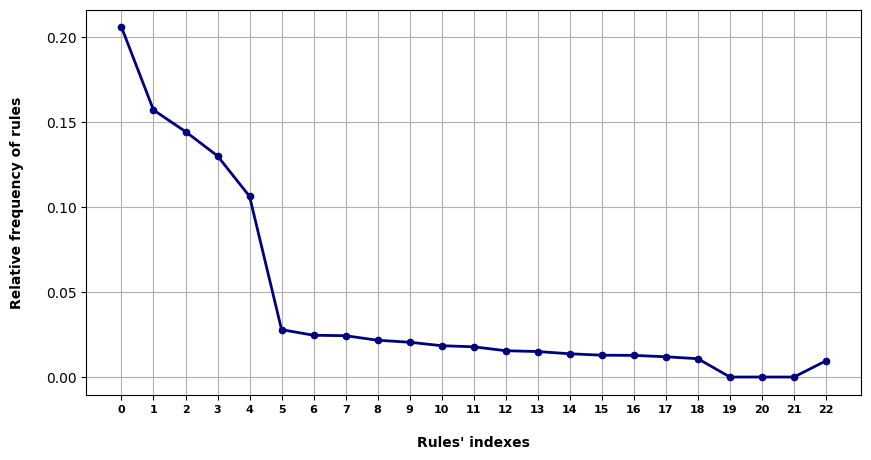

In [73]:
a.plot_profile(g_profile_a, list(g_general_mapping.keys()))

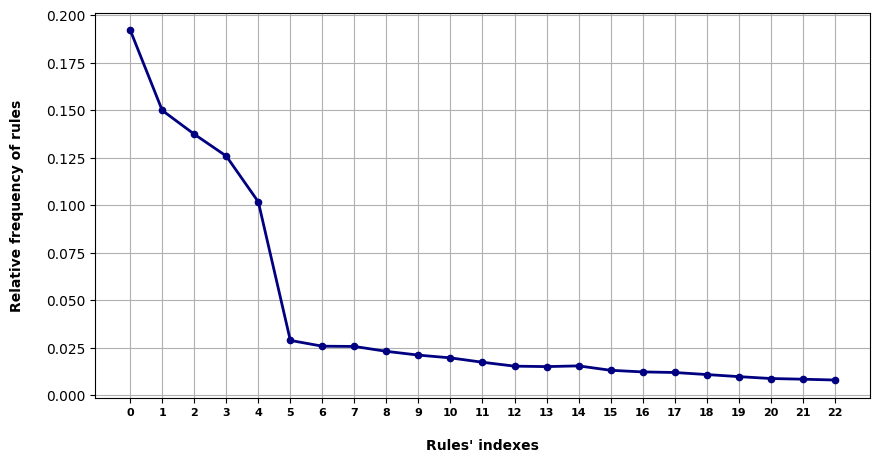

In [64]:
a.plot_profile(g_profile_b, list(g_general_mapping.keys()))

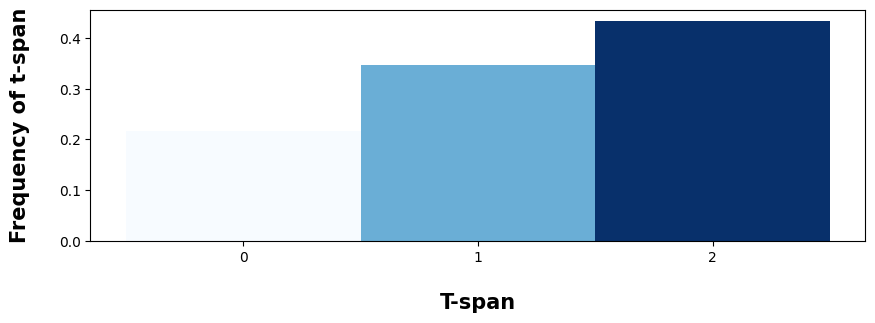

In [85]:
spans_b = a.t_span_plot(g_new_pattern_list_b,
               cmap = 'Blues',
                fs = (10,3),
                 cbar_ticks_size = 25,
                 plot_params = {'ms' : 9, 'lw' : 2, 'style':'.-'},
                 ticks_params = {'fontsize_x':10, 'rotation_x':0,'fontweight_x':'bold',
                                'fontsize_y':10, 'rotation_y':0,'fontweight_y':'bold'},
                 label_params = {'xlabel': "\nT-span", 'fontsize_x' :15, 'fontweight_x':'bold',
                                'ylabel': "Frequency of t-span\n", 'fontsize_y' :15, 'fontweight_y':'bold'})
    

## Evomine

In [88]:
general_mapping = pickle.load(open('evomine_general_mapping.p','rb'))
e_profile = a.get_profiles(e_new_support, list(general_mapping.keys()), './processed-outputs/',)
e_profile_b = a.get_profiles(e_new_support_b, list(general_mapping.keys()), './processed-outputs/',)

In [100]:
len(e_profile), len(e_profile_b)

(18, 18)

In [112]:
reload(a)

<module 'analysis' from '/root/work/analysis.py'>

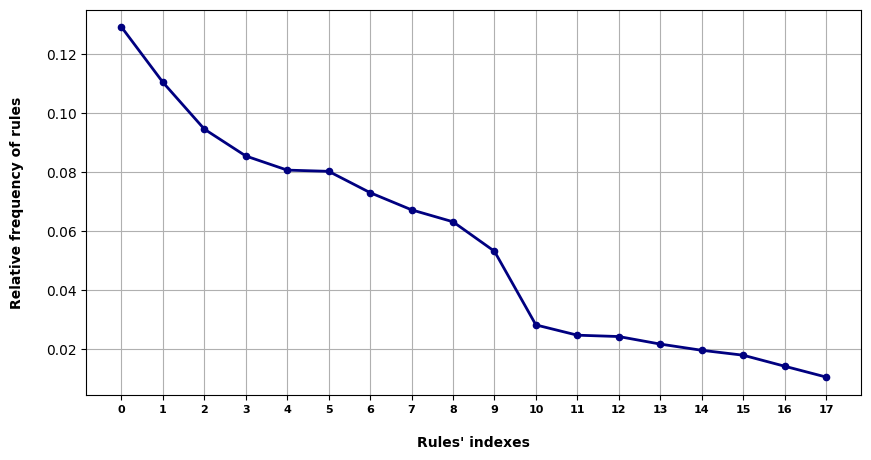

In [106]:
a.plot_profile(e_profile, list(general_mapping.keys()))

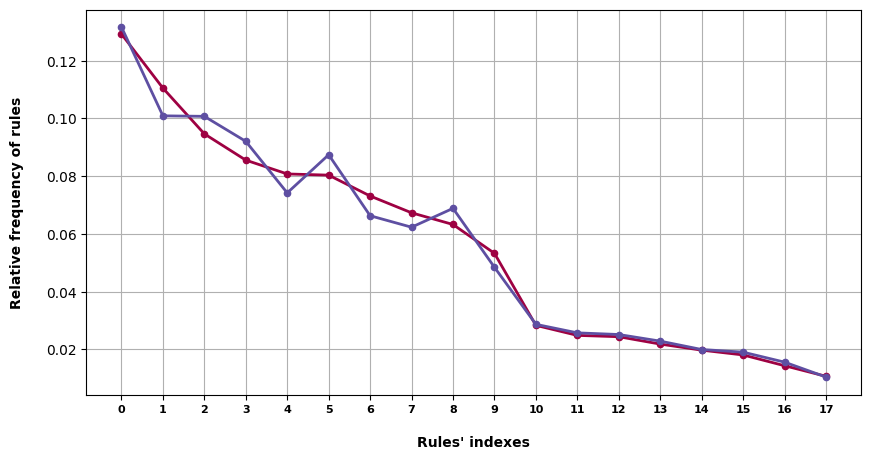

In [115]:
a.plot_profile([e_profile,e_profile_b], list(general_mapping.keys()), single_profile=False, labels=['2003-2005','2005-2007'])

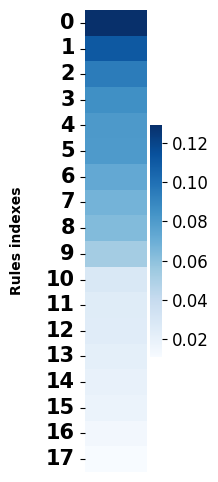

In [118]:
a.plot_heatmap(e_profile, 
               list(general_mapping.keys()),
               fs=(1,6),
               cbar_ticks_size = 12,
               ticks_params = {'fontsize_x':25, 'rotation_x':0,'fontweight_x':'bold',
                                'fontsize_y':15, 'rotation_y':0,'fontweight_y':'bold'},
              label_params = {'xlabel': "", 'fontsize_x' :10, 'fontweight_x':'bold',
                                'ylabel': "Rules indexes\n", 'fontsize_y' :10, 'fontweight_y':'bold'})


# drawing 

## GERM

In [121]:
g_new_pattern_list[10]

{'edges': [(0, 1, 0), (0, 3, 1), (1, 2, 1)], 'old-ids': 10}

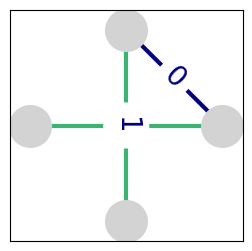

In [127]:
d.draw_pattern_ger('germ', g_new_pattern_list[10]['edges'], w = 3,h = 3)

In [160]:
[e['edges'] for e in list(g_new_pattern_list.values()) if e]

[[(0, 1, 0)],
 [(0, 1, 0), (1, 2, 0)],
 [(0, 1, 0), (0, 2, 0), (1, 2, 0)],
 [(0, 1, 0), (1, 2, 0), (2, 3, 0)],
 [(0, 1, 0), (1, 2, 0), (1, 3, 0)],
 [(0, 1, 0), (1, 2, 1)],
 [(0, 1, 0), (1, 2, 1), (2, 3, 1)],
 [(0, 1, 0), (1, 2, 0), (2, 3, 1)],
 [(0, 1, 0), (1, 2, 0), (1, 3, 1)],
 [(0, 1, 0), (1, 2, 1), (1, 3, 1)],
 [(0, 1, 0), (0, 3, 1), (1, 2, 1)],
 [(0, 1, 0), (1, 2, 2)],
 [(0, 1, 0), (1, 2, 2), (2, 3, 2)],
 [(0, 1, 0), (1, 2, 0), (2, 3, 2)],
 [(0, 1, 0), (1, 2, 1), (2, 3, 0)],
 [(0, 1, 0), (1, 2, 0), (1, 3, 2)],
 [(0, 1, 0), (1, 2, 2), (1, 3, 2)],
 [(0, 1, 0), (0, 2, 1), (1, 2, 1)],
 [(0, 1, 0), (0, 3, 2), (1, 2, 2)],
 [(0, 1, 0), (0, 3, 2), (1, 2, 1)]]

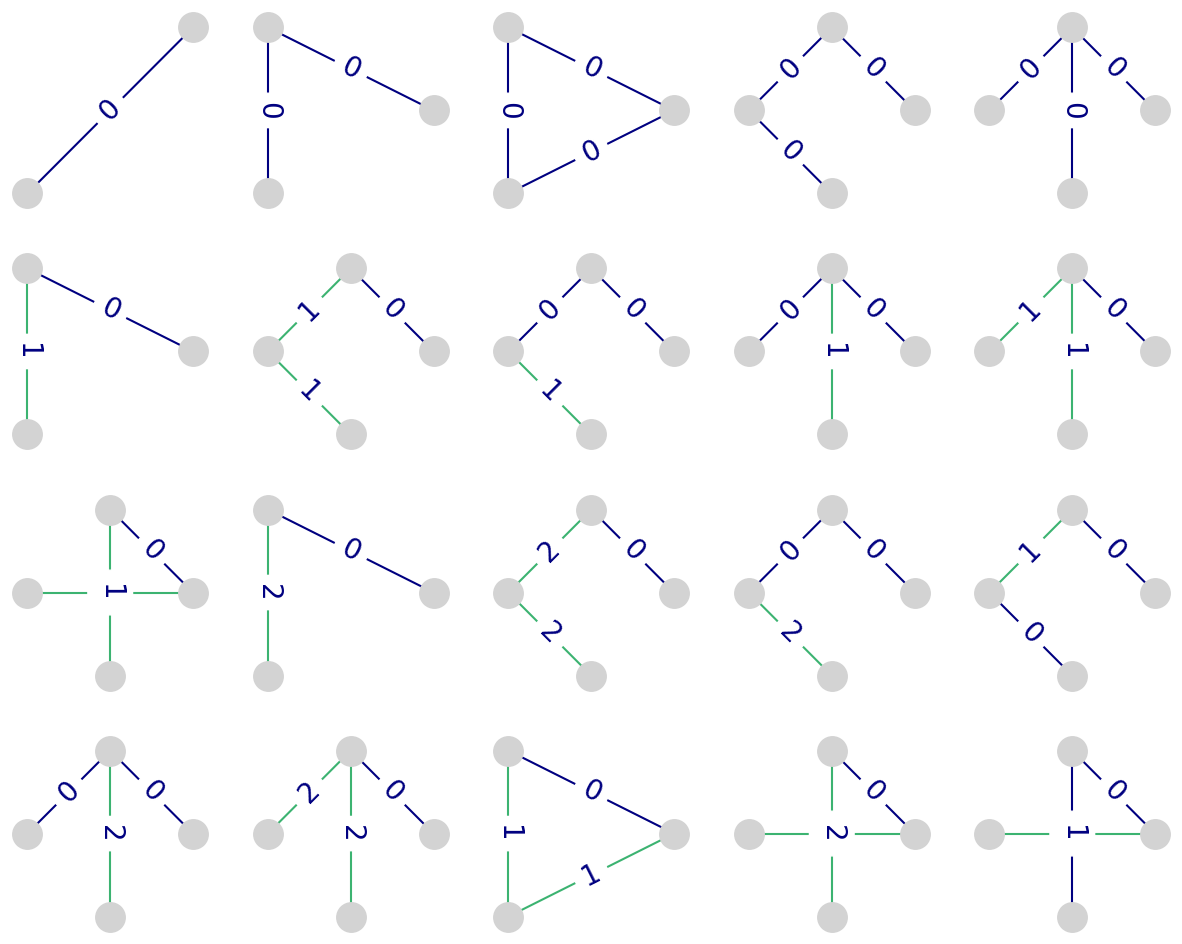

In [166]:
d.draw_several_patterns('germ', [e['edges'] for e in list(g_new_pattern_list.values()) if e], 
                          columns = 5, w_box = 3)


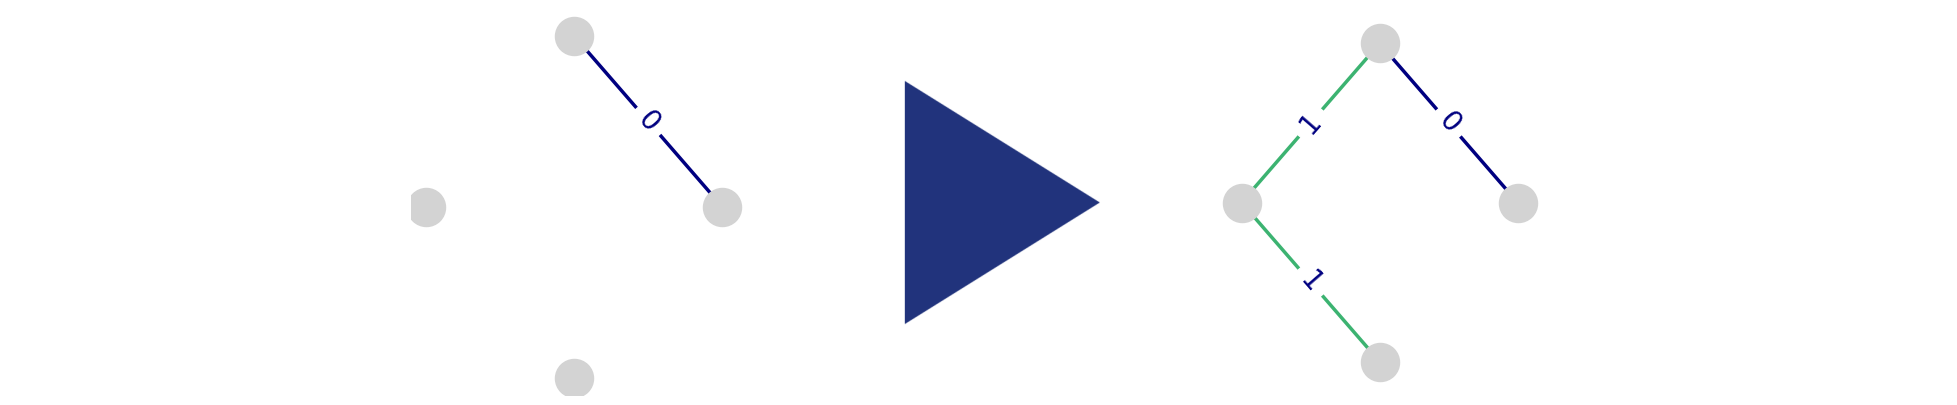

In [133]:
d.draw_rule('germ', g_new_pattern_list[12]['edges'], w_box = 5)

## EvoMine

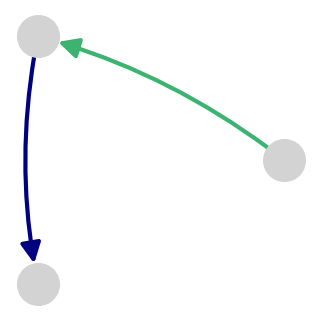

In [181]:
d.draw_pattern_ger('evomine', e_new_pattern_list[10]['edges'],
                             w = 3,h = 3)

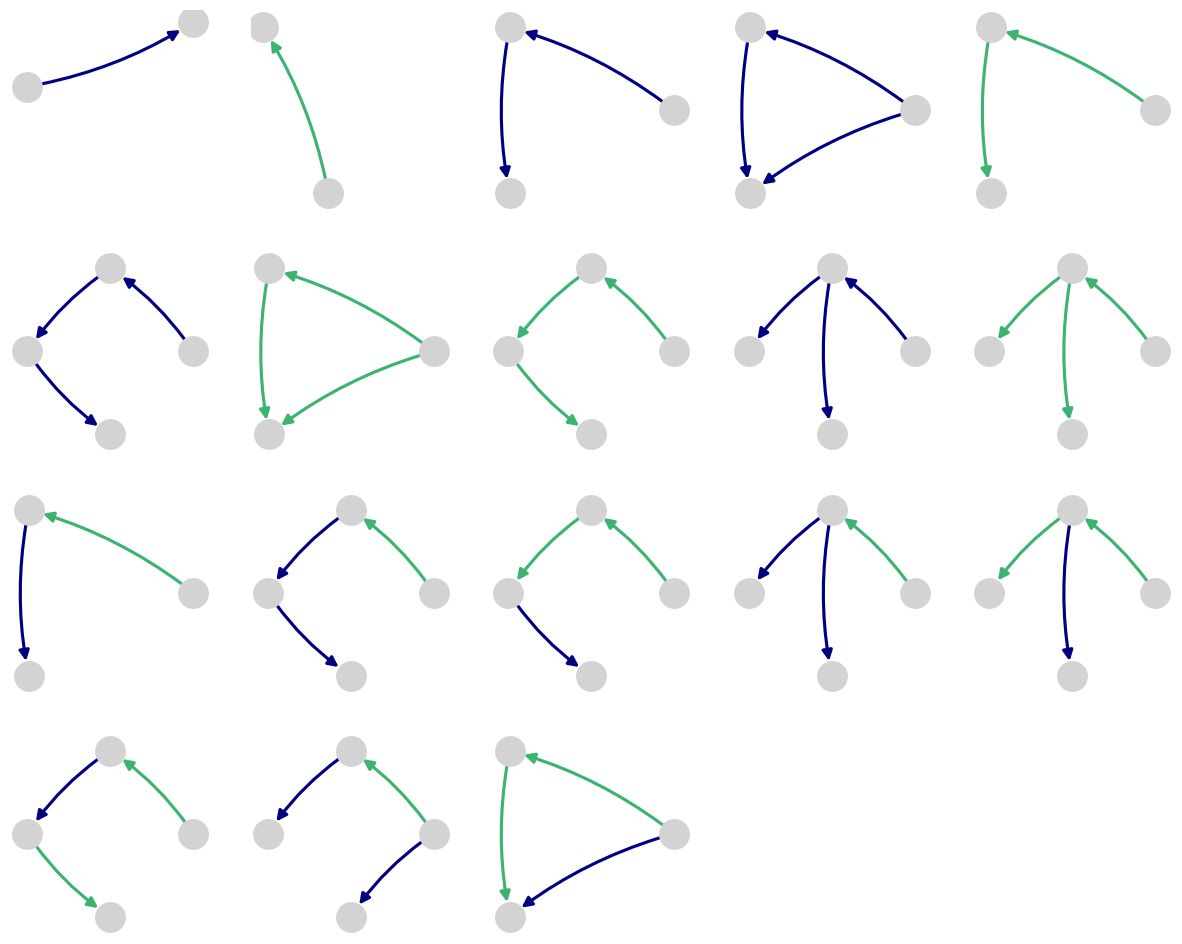

In [193]:
d.draw_several_patterns('evomine', [e['edges'] for e in e_new_pattern_list.values() if e], 
                          columns = 5, w_box = 3)

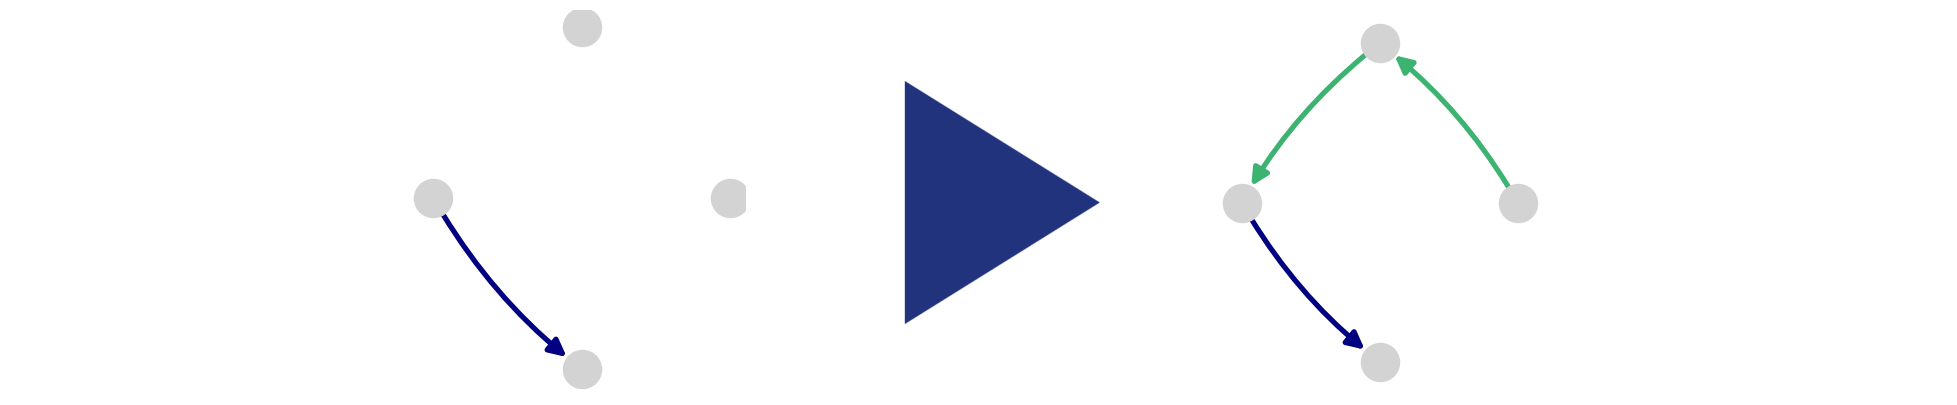

In [187]:
d.draw_rule('evomine', e_new_pattern_list[12]['edges'], w_box = 5)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dc2d93ac-1bc6-4a4f-acf0-97569b1e724b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>